# How to Forecast a Time Series with Python

This notebook is replicated from Jose Portilla's blog https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

## Time Series Basics

Time Series data is experimental data that has been observed at different points in time (usually evenly spaced, like once a day). For example, the data of airline ticket sales per day is a time series. However, just because a series of events has a time element does not automatically make it a time series, such as the dates of major airline disasters, which are randomly spaced and are not time series. These types of random processes are known as point process.

Time Series have several key features such as trend, seasonality, and noise.

What we'll be doing in this notebook is analyzing these features of a time series data set, and then seeing if we can use mathematical models to forecast into the future. We'll also see how we can split our original time series data set to evaluate how well our model predicts the future.

## Forecasting with ARIMA
`Prediction is very difficult, especially about the future`.

Forecasting is the process of making predictions of the future, based on past and present data. One of the most common methods for this is the `ARIMA` model, which stands for `AutoRegressive Integrated Moving Average`.

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: `seasonality`, `trend`, and `noise`. These parameters are labeled **p**, **d**, and **q**.

**p** is the parameter associated with the auto-regressive aspect of the model, which incorporates past values. For example, forecasting that if it rained a lot over the past few days, you state its likely that it will rain tomorrow as well.

**d** is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series. You can imagine an example of this as forecasting that the amount of rain tomorrow will be similar to the amount of rain today, if the daily amounts of rain have been similar over the past few days.

**q** is the parameter associated with the moving average part of the model.

If our model has a seasonal component (we'll show this in more detail later), we use a `seasonal ARIMA model (SARIMA)`. In that case we have another set of parameters: **P**, **D**, and **Q** which describe the same associations as **p**, **d**, and **q**, but correspond with the seasonal components of the model.

The methods we will employ in this notebook example will only take in data from a uni-variate time series. That means we really are only considering the relationship between the y-axis value the x-axis time points. We're not considering outside factors that may be affecting the time series.

A common mistake beginners make is they immediately start to apply ARIMA forecasting models to data that has many outside factors, such as stock prices or a sports team's performance. While ARIMA can be a powerful and relevant tool for times series related to those topics, if you only use it by itself and don't account for outside factors, such as a CEO getting fired or an injury on the team, you won't have good results. Keep this in mind as you begin to apply these concepts to your own data sets.

## Variation
One of the most important features of a time series is variation. Variations are patterns in the times series data. A time series that has patterns that repeat over known and fixed periods of time is said to have `seasonality`. `Seasonality` is a general term for variations that periodically repeat in data. In general, we think of variations as 4 categories.: `Seasonal`, `Cyclic`, `Trend`, and `Irregular fluctuations`.

Seasonal variation is usually defined as variation that is annual in period, such as swimsuit sales being lower in winter and higher in summer. Cyclic Variation is a variation that occurs at other fixed periods, such as the daily variation in temperature. Both Seasonal and Cyclic variation would be examples of seasonality in a time series data set.

Trends are long-term changes in the mean level, relative to the number of observations.

## Our Data

Let's explore the Industrial production of electric and gas utilities in the United States, from the years 1985-2018, with our frequency being Monthly production output.

You can access this data here: https://fred.stlouisfed.org/series/IPG2211A2N

This data measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

sns.set(context='notebook', style='whitegrid', rc={"figure.figsize": (18,4)})

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 18,4

In [6]:
# to get rid of the unnecessary statsmodels package warnings
import warnings
warnings.filterwarnings("ignore")

In [7]:
# setting random seed for notebook reproducability
rnd_seed=42
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

## Processing the Data
We'll need to do some quick processing to convert this data to have a time series index. Luckily Pandas makes this easy, let's quickly check the head of the data (the first 5 rows) to see what default format it comes in:

In [8]:
data = pd.read_csv("data/electric-production.csv")
data.head()

,DATE,IPG2211A2N
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


Right now our index is actually just a list of auto-generated numbers, we'll want to adjust these to be timestamps, that way our forecasting analysis will be able to interpret these values:

In [9]:
data['DATE'] = pd.to_datetime(data['DATE'])

In [10]:
data.set_index(keys=['DATE'], drop=True, inplace=True)

Let's also rename this column since its hard to remember what "IPG2211A2N" code stands for:

In [11]:
data.columns = ['Energy_Production']

In [12]:
data.head()

,Energy_Production
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


**Missing Values:** Let's first make sure that the data doesn't have any missing data points:

In [13]:
data[pd.isnull(data['Energy_Production'])]

,Energy_Production
DATE,


### Visualize the Time Series:

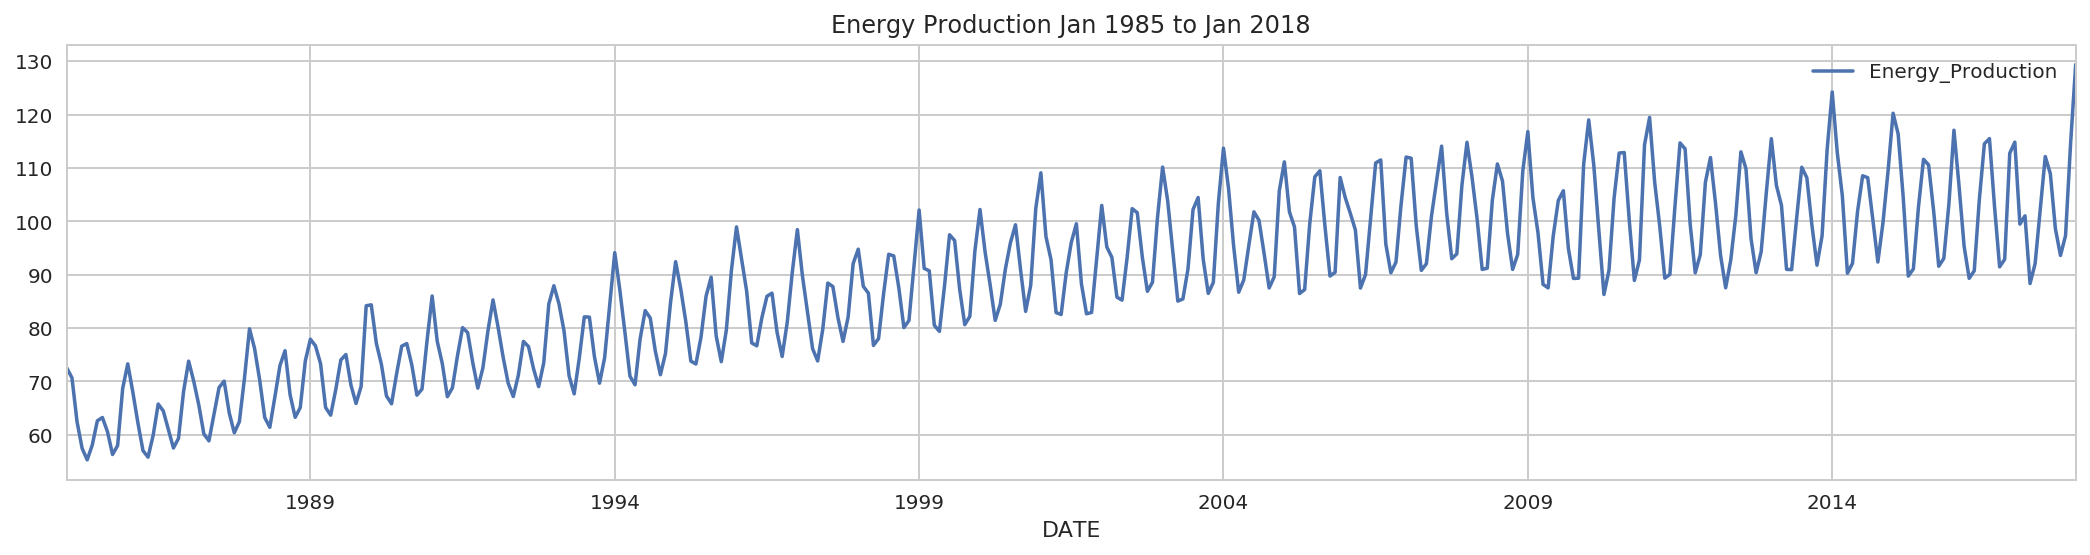

In [14]:
data.plot()
plt.title("Energy Production Jan 1985 to Jan 2018");

### Decomposition:
Here we can see there is an upward trend. We can use `statsmodels` to perform a decomposition of this time series. The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns. With statsmodels we will be able to see the `trend`, `seasonal`, and `residual components` of our data.

We can use an `additive` model when it seems that the trend is more linear and the seasonality and trend components seem to be constant over time (e.g. every year we add 100 units of energy production). A `multiplicative` model is more appropriate when we are increasing (or decreasing) at a non-linear rate (e.g. each year we double the amount of energy production everyyear).

Based off the previous chart, it looks like the trend in these earlier days is slightly increasing at a higher rate than just linear (although it is a bit hard to tell from this one plot, we can always experiment with additive versus multiplicative methods.).

Again, Python and Statsmodels make this task incredibly easy in just a few lines of code:

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data, model='multiplicative')

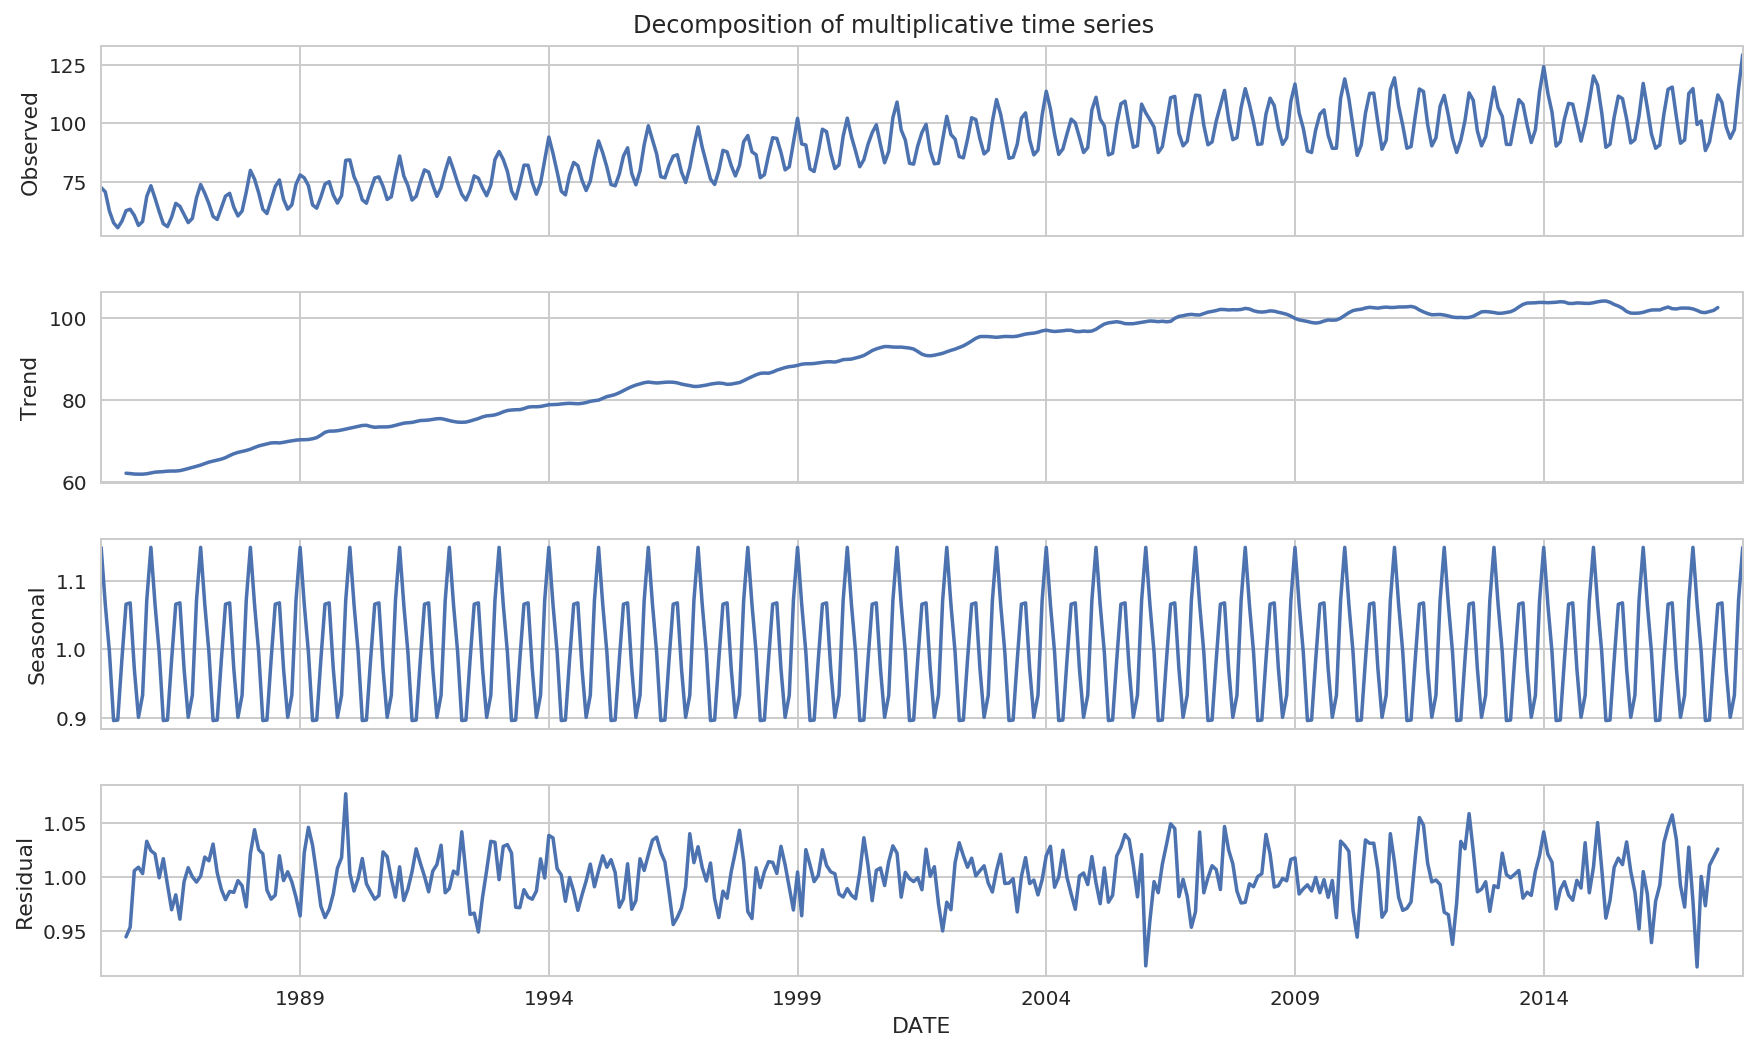

In [16]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series');

From the plot above we can clearly see the seasonal component of the data, and we can also see the separated upward trend of the data.

Trends can be upward or downward, and can be linear or non-linear. It is important to understand your data set to know whether or not a significant period of time has passed to identify an actual trend.

Irregular fluctuations are abrupt changes that are random and unpredictable.

## Performing the Seasonal ARIMA
Now that we've analyzed the data, we can clearly see we have a time series with a seasonal component, so it make sense to use a Seasonal ARIMA model. In order to do this we will need to choose p,d,q values for the ARIMA, and P,D,Q values for the Seasonal component.

There are many ways to choose these values statistically, such as looking at `auto-correlation plots`, `correlation plots`, domain experience, etc.

One simple approach is to perform a grid search over multiple values of p,d,q,P,D,and Q using some sort of performance criteria. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models.

The AIC value will allow us to compare how well a model fits the data and takes into account the complexity of a model, so models that have a better fit while using fewer features will receive a better (lower) AIC score than similar models that utilize more features.

The `pyramid-arima` library for Python allows us to quickly perform this grid search and even creates a model object that you can fit to the training data.

This library contains an `auto_arima` function that allows us to set a range of p,d,q,P,D,and Q values and then fit models for all the possible combinations. Then the model will keep the combination that reported back the best AIC value.

**Installing Pyramid **  
[http://pyramid-arima.readthedocs.io/en/latest/setup.html#installation]  
!conda install -c anaconda numpy (If there is an import error with pyramid then update numpy to 1.14)  
!pip install pyramid-arima

In [17]:
from pyramid.arima import auto_arima

The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [18]:
stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True) 

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1782.527, BIC=1802.447, Fit time=1.509 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1942.040, BIC=1957.976, Fit time=0.383 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1837.289, BIC=1853.224, Fit time=0.563 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1783.916, BIC=1807.820, Fit time=1.965 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1920.884, BIC=1936.820, Fit time=0.605 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1784.378, BIC=1808.282, Fit time=5.517 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1781.951, BIC=1809.838, Fit time=7.031 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1837.164, BIC=1861.067, Fit time=2.056 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_orde

In [19]:
stepwise_model.aic()

1771.2948202763664

The resulting best model parameters gave us an AIC value of 1771.29.

We now have a model that we can fit, in order to do this , we will need training data and test data.

## Train Test Split
We can then fit the stepwise_model object to a training data set. Because this is a time series forecast, we will "chop off" a portion of our latest data and use that as the test set. Then we will train on the rest of the data and forecast into the future. Afterwards we can compare our forecast with the section of data we chopped off.

We'll train on 20 years of data, from the years 1985 - 2015 and test our forecast on the years after that and compare it to the real data:

In [20]:
train = data.loc['1985-01-01':'2014-12-01']

In [21]:
train.tail()

,Energy_Production
DATE,
2014-08-01,108.1940
2014-09-01,100.4172
2014-10-01,92.3837
2014-11-01,99.7033
2014-12-01,109.3477


In [22]:
test = data.loc['2015-01-01':]

In [23]:
test.head()

,Energy_Production
DATE,
2015-01-01,120.2696
2015-02-01,116.3788
2015-03-01,104.4706
2015-04-01,89.7461
2015-05-01,91.0930


In [24]:
test.tail()

,Energy_Production
DATE,
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359
2017-12-01,114.7212
2018-01-01,129.4048


## Train the Model
We can then train the model by simply calling `.fit` on the stepwise model and passing in the training data:

In [25]:
len(train), len(test)

(360, 37)

In [26]:
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(2, 1, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

## Evaluation
Now that the model has been fitted to the training data, we can forecast into the future. Recall that our test data set is from 2015-01-01 all the way to 2018-01-01. So if we check the length of our test data we get 37 rows, or 37 time periods. That is the value we will use for our `.predict()` method call:

In [27]:
test_predictions = stepwise_model.predict(n_periods=37)

In [28]:
test_predictions

array([118.03317506, 108.75281867, 100.4591885 ,  89.87834865,
        92.28532001, 102.61388393, 111.59322396, 110.72303388,
        99.73218916,  91.87265353,  96.3924746 , 109.4973043 ,
       117.42636707, 108.22377707, 100.58146069,  90.2754225 ,
        92.23671791, 102.5108521 , 111.94969247, 110.76160083,
        99.62093773,  91.85168481,  96.07780262, 110.36022361,
       118.70738932, 109.08768556, 101.45526938,  90.37695265,
        92.23254389, 102.38641319, 111.35717789, 110.26908541,
        99.74913761,  91.9358697 ,  96.7057353 , 110.27807632,
       118.75397251])

Let's reorganize this set of predictions by creating a dataframe that contains our future forecast and then concatenating that with the original data.

We can then plot this to view how well our prediction forecast matched up with the test set for which we have the real data:

In [29]:
test_predictions = pd.DataFrame(test_predictions, index=test.index, columns=['Prediction'])

In [30]:
test_predictions.head()

,Prediction
DATE,
2015-01-01,118.033175
2015-02-01,108.752819
2015-03-01,100.459188
2015-04-01,89.878349
2015-05-01,92.285320


In [31]:
test.head()

,Energy_Production
DATE,
2015-01-01,120.2696
2015-02-01,116.3788
2015-03-01,104.4706
2015-04-01,89.7461
2015-05-01,91.0930


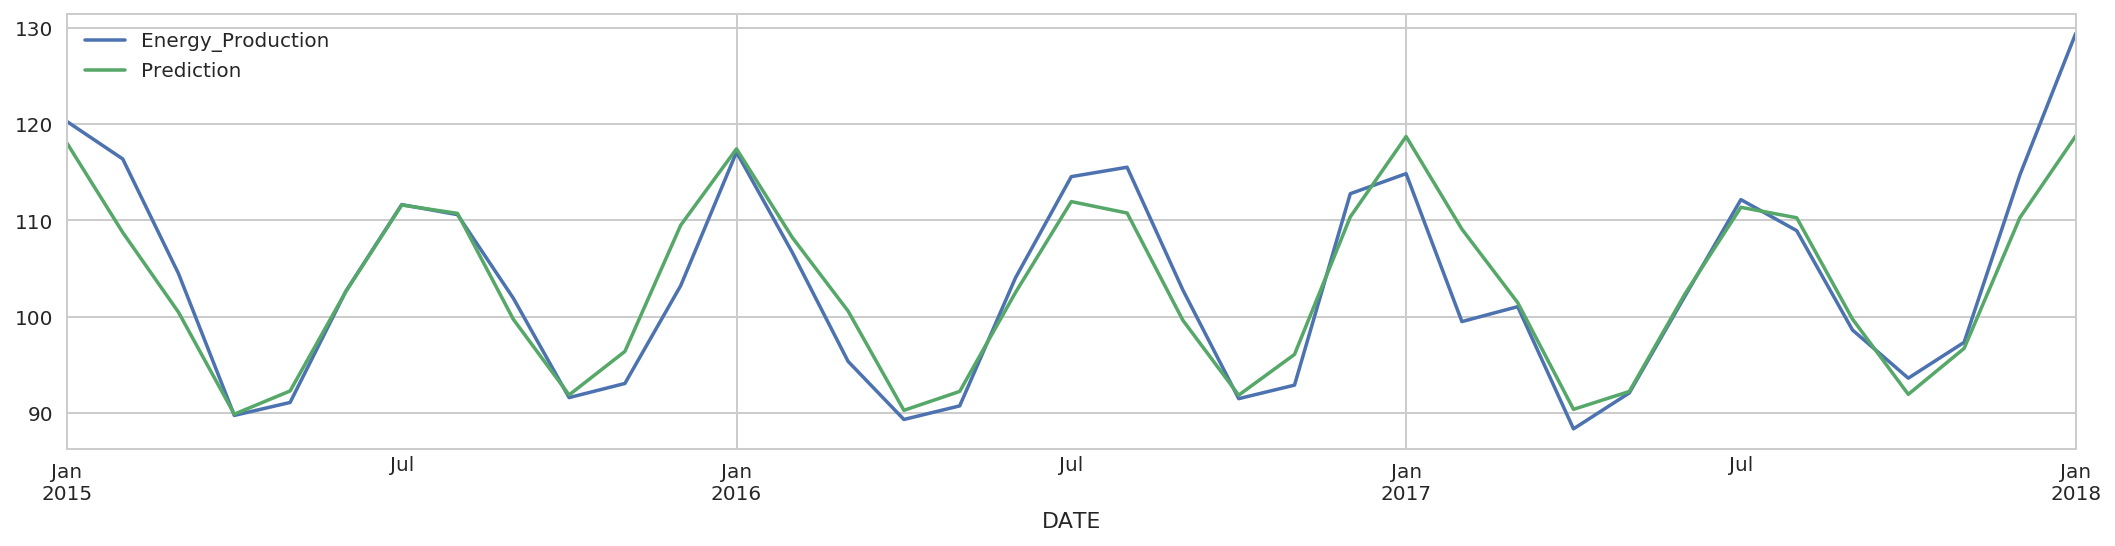

In [32]:
pd.concat([test, test_predictions], axis=1).plot();

We can also just compare this to the entire data set to get a larger picture of the context of our prediction.

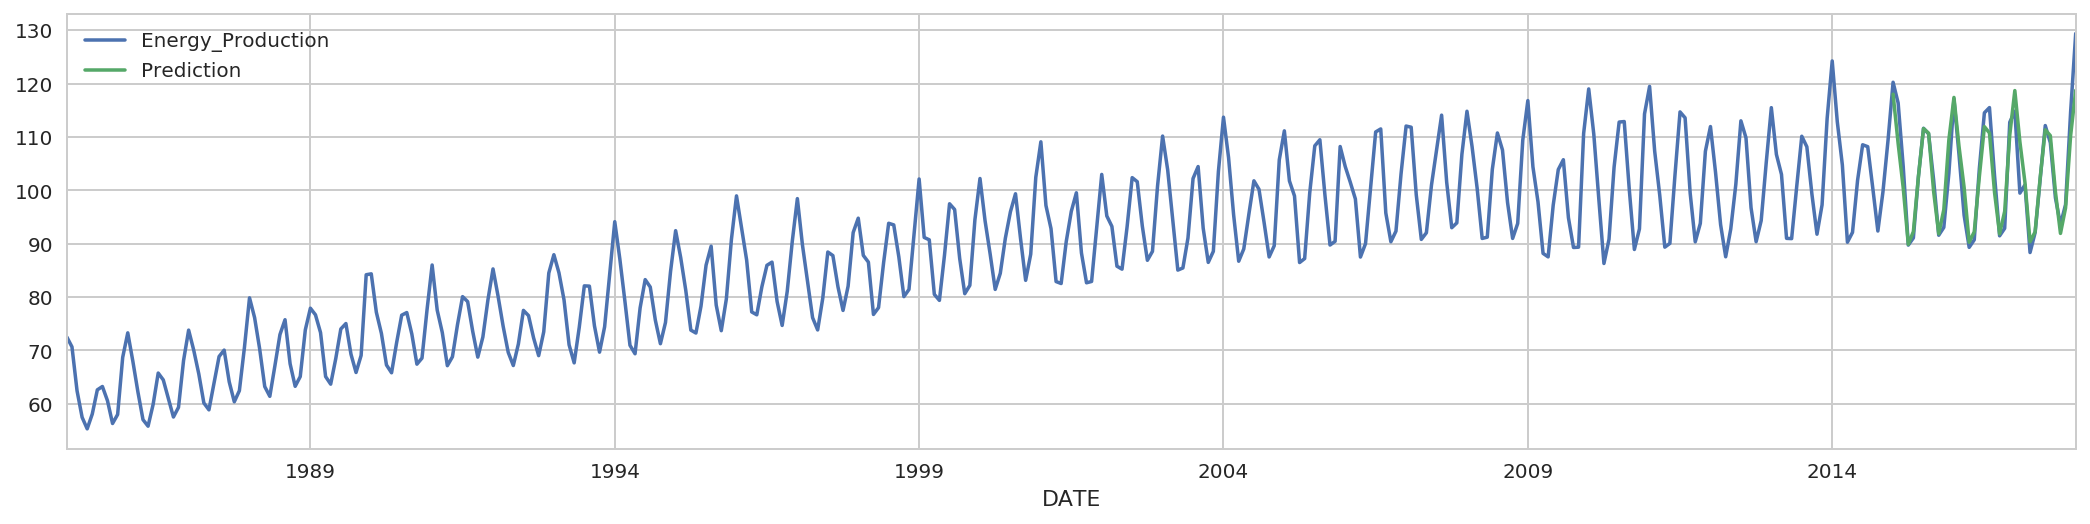

In [33]:
pd.concat([data, test_predictions], axis=1).plot();

## Next Steps
Now that we've evaluated our data on the test set and our satisfied with the performance, the next step would be to refit our model to our entire data set and then forecast into the real future. We will predict in future for 36 months.

In [34]:
future_forecast = stepwise_model.fit(data).predict(n_periods=36)

In [35]:
data.index

DatetimeIndex(['1985-01-01', '1985-02-01', '1985-03-01', '1985-04-01',
               '1985-05-01', '1985-06-01', '1985-07-01', '1985-08-01',
               '1985-09-01', '1985-10-01',
               ...
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
               '2017-12-01', '2018-01-01'],
              dtype='datetime64[ns]', name='DATE', length=397, freq=None)

In [36]:
future_index = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=36, freq='MS')
future_index

DatetimeIndex(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01'],
              dtype='datetime64[ns]', freq='MS')

In [37]:
future_forecast = pd.DataFrame(future_forecast, index=future_index, columns=['Prediction'])

In [38]:
pd.concat([data, future_forecast], axis=1).tail()

,Energy_Production,Prediction
2020-09-01,NaN,100.670546
2020-10-01,NaN,92.329649
2020-11-01,NaN,95.540621
2020-12-01,NaN,110.864057
2021-01-01,NaN,120.634941


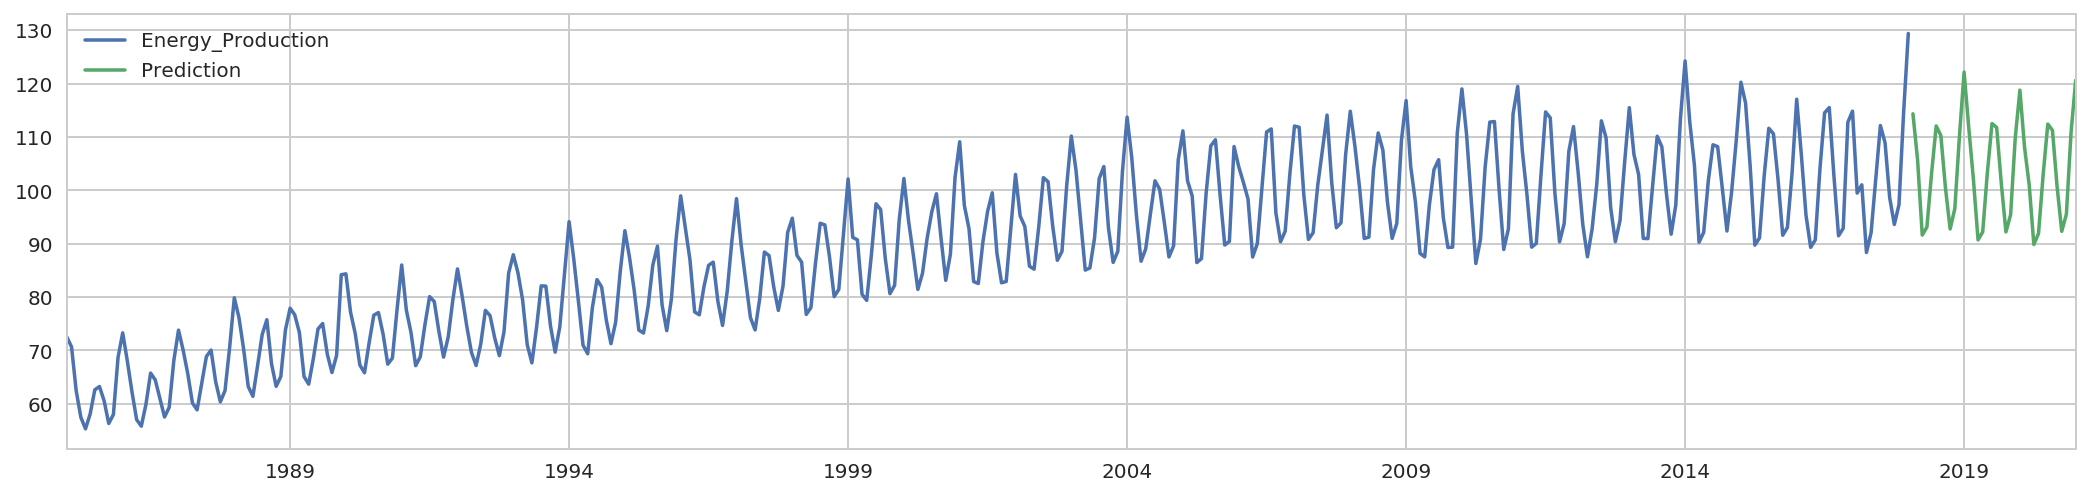

In [39]:
pd.concat([data, future_forecast], axis=1).plot();